## Analyses of similarity correspondences between embedding spaces and expert piles

in this notebook we compare the similarity / embedding spaces from the con espressione pile sorting and embedding models:
- CLAP language model
- ADA embedding model
- EWE embedding model
- GTE embedding model
- BGE embedding model

In [20]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

import os
os.environ["OMP_NUM_THREADS"] = "1"
                    
from collections import defaultdict
import pandas as pd
import scipy
from scipy.spatial import procrustes, ConvexHull

from collections import defaultdict
import copy

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import TweedieRegressor, LinearRegression
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import (PCA, NMF, FastICA, FactorAnalysis, KernelPCA)
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer

# skhubness
from skhubness import Hubness
from skhubness.reduction import MutualProximity
%matplotlib inline

### load preprocessed data

- term_freq: (45, 150) the occurence of each of the 150 terms in the 45 performances
- dtm = term_freq, but sparse
- piles1: dict of pile 1 (strings, 25), storing terms each (strings)
- piles2: dict of pile 2 (strings, 19), storing terms each (strings)
- piece_performer_list: list of strings of the 45 performances (piece + performer, unique)
- pieces_list: list of strings of the piece names (45, repeats)
- performer_list: list of strings of the performers names (45, repeats)
- pieces_music_id_list: list of music IDs of the 45 performances (note, these are not array idx!)
- terms: list of terms, sorted alphabetically
- pile_names: list of string names of the piles
- term_per_pile: dict of piles (strings, 44, both pile groups), storing term idx each (to index "terms")
- term_per_perf: dict of performance names (strings), storing term idx each (to index "terms")
- pile_idx_per_term: dict of tuples
- term_similarity (150,150), similarity based on cooccurence in piles and performances
- term_similarity_weighted
- term_similarity_only_performances
- term_similarity_only_piles
- term_similarity_only_pile1
- term_similarity_only_pile2
- term_embeddings_ada_npy (150, 1536), embeddings from openai's ada model
- term_embeddings_ada_context_npy (150, 1024), embeddings from openai's ada model using context prompts
- term_embeddings_clap_npy (150, 1024), embeddings from microsoft's clap model
- term_embeddings_clap_context_npy (150, 1024), embeddings from microsoft's clap model using context prompts
- term_embeddings_bge_npy (150, 1024), embeddings from baai's bge model
- term_embeddings_bge_context_npy (150, 1024), embeddings from baai's bge model using context prompts
- term_embeddings_gte_npy (150, 1024), embeddings from damo's gte model
- term_embeddings_gte_context_npy (150, 1024), embeddings from damo's gte model using context prompts
- term_embeddings_ewe_npy (150, 1024), embeddings from the EWE model
- audio_embeddings (45, 1024), audio embeddings from microsoft's clap model
- file_paths_audio, list of file paths corresponding to the audio embeddings
- music_ids_audio, list of music ids corresponding to the audio embeddings
- similarity_ada (150,150), cosine similarity of ada embeddings
- similarity_ada_context (150,150), cosine similarity of ada embeddings with context prompts
- similarity_clap (150,150), cosine similarity of clap embeddings
- similarity_clap_context (150,150), cosine similarity of clap embeddings with context prompts
- similarity_audio (150,150), cosine similarity of clap audio embeddings
- similarity_ewe (150,150), cosine similarity of ewe embeddings

In [2]:
data = np.load("data/preprocessed_embedding_data_complete.npz", allow_pickle=True)
term_freq=data["term_freq"]
dtm=data["dtm"]
piles1=data["piles1"]
piles2=data["piles2"]
# helpers
piece_performer_list=data["piece_performer_list"] 
pieces_list=data["pieces_list"]
performer_list=data["performer_list"]
pieces_music_id_list=data["pieces_music_id_list"]
terms=data["terms"]
pile_names=data["pile_names"]
term_per_pile=data["term_per_pile"]
term_per_perf = data["term_per_perf"]
pile_idx_per_term = data["pile_idx_per_term"]
# pile similarities
term_similarity_original=data["term_similarity"]
term_similarity_weighted=data["term_similarity_weighted"]
term_similarity_only_performances=data["term_similarity_only_performances"]
term_similarity_only_piles=data["term_similarity_only_piles"]
term_similarity_only_pile1=data["term_similarity_only_pile1"]
term_similarity_only_pile2=data["term_similarity_only_pile2"]
# embeddings
term_embeddings_ada_npy=data["term_embeddings_ada_npy"]
term_embeddings_ada_context_npy=data["term_embeddings_ada_context_npy"]
term_embeddings_bge_npy=data["term_embeddings_bge_npy"]
term_embeddings_bge_context_npy=data["term_embeddings_bge_context_npy"]
term_embeddings_gte_npy=data["term_embeddings_gte_npy"]
term_embeddings_gte_context_npy=data["term_embeddings_gte_context_npy"]
term_embeddings_clap_npy=data["term_embeddings_clap_npy"]
term_embeddings_clap_context_npy=data["term_embeddings_clap_context_npy"]
term_embeddings_ewe_npy=data["term_embeddings_ewe_npy"]
audio_embeddings=data["audio_embeddings"]
# embedding helpers
file_paths_audio=data["file_paths_audio"]
music_ids_audio=data["music_ids_audio"]
# similarity matrices
similarity_ada=data["similarity_ada"]
similarity_clap=data["similarity_clap"]
similarity_ada_context=data["similarity_ada_context"]
similarity_clap_context=data["similarity_clap_context"]
similarity_gte=data["similarity_gte"]
similarity_bge=data["similarity_bge"]
similarity_gte_context=data["similarity_gte_context"]
similarity_bge_context=data["similarity_bge_context"]
similarity_audio=data["similarity_audio"]
similarity_ewe=data["similarity_ewe"]
similarity_ewe_orig=data["similarity_ewe"]

In [3]:
print(term_embeddings_ada_npy.shape)
print(term_embeddings_gte_npy.shape)
print(term_embeddings_bge_npy.shape)
print(term_embeddings_ewe_npy.shape)
print(term_embeddings_clap_npy.shape)

(150, 1536)
(150, 1024)
(150, 1024)
(150, 300)
(150, 1024)


In [4]:
no_of_terms = len(term_similarity_weighted)
#max_sim = term_similarity_weighted.max()
#term_similarity_weighted[np.arange(no_of_terms),np.arange(no_of_terms)] = max_sim + 1

# normalize EWE
term_embeddings_ewe_npy = term_embeddings_ewe_npy / np.sqrt(np.outer((term_embeddings_ewe_npy**2).sum(axis=1), np.ones(300)))
similarity_ewe = np.matmul(term_embeddings_ewe_npy, term_embeddings_ewe_npy.T)

# set the main term_similarity vairable
term_similarity = term_similarity_weighted

In [5]:
# add minimal noise to the discrete similarities
rng = np.random.default_rng(1984)

variance = 0.001**2
noise_embed = rng.normal(0,np.sqrt(variance),(150,150)) 
noise = noise_embed*noise_embed.T
term_similarity_only_pile1 += noise
term_similarity_only_pile1[term_similarity_only_pile1>0.9] = 1.0 

noise_embed = rng.normal(0,np.sqrt(variance),(150,150)) 
noise = noise_embed*noise_embed.T
term_similarity_only_pile2 += noise
term_similarity_only_pile2[term_similarity_only_pile2>0.9] = 1.0 

noise_embed = rng.normal(0,np.sqrt(variance),(150,150)) 
noise = noise_embed*noise_embed.T
term_similarity_only_piles += noise
noise_embed = rng.normal(0,np.sqrt(variance),(150,150)) 
noise = noise_embed*noise_embed.T
term_similarity_only_performances += noise
noise_embed = rng.normal(0,np.sqrt(variance),(150,150)) 
noise = noise_embed*noise_embed.T
term_similarity += noise
term_similarity[term_similarity>0.9] = 1.0 


In [6]:
# compute Multidimensional scaling
rng = np.random.RandomState(1984)

def compute_mds(similarity_matrix, 
                noise_level = 0.001,
               dimensions = 64):
    size = similarity_matrix.shape[0]
    # dissimilarity = np.exp(- 20 * similarity_matrix)
    dissimilarity = similarity_matrix.max() - similarity_matrix
    dissimilarity[np.arange(size), np.arange(size)] = 0
    # Add noise to the similarities
    noise = noise_level * rng.rand(size, size)
    noise = noise + noise.T
    noise[np.arange(size), np.arange(size)] = 0
    dissimilarity += np.clip(noise,-noise_level, noise_level)

    mds = MDS(dimensions, 
              metric=True, 
              dissimilarity='precomputed',
              n_init=10, max_iter=10000,
              random_state=1984,
             normalized_stress=False)
    
    terms_mds = mds.fit_transform(dissimilarity)
    print(mds.stress_)
    terms_mds /= np.linalg.norm(terms_mds, ord = "fro")
    return terms_mds

def compute_mds_dis(dissimilarity, 
                noise_level = 0.01,
               dimensions = 30):
    
    mds = MDS(dimensions, 
              metric=True, 
              dissimilarity='precomputed',
              n_init=10, max_iter=10000,
              random_state=1984,
             normalized_stress=False)
  
    terms_mds = mds.fit_transform(dissimilarity)
    print("stress" , mds.stress_)
    return terms_mds

In [7]:
dims = 2
# compute term_mds for visualizations
terms_mds = compute_mds(term_similarity, dimensions= dims)

1085.4597448934483


### plots of MDS spaces

In [8]:
def plot_mds(mds_data,
             pile_names=pile_names,
             pile_idx_per_term=pile_idx_per_term,
             all_terms=terms,
            save_figure=False):
    """
    a full plot with terms colored according to piles, bot pile groups represented
    """
    fig, ax = plt.subplots(1, figsize=(13, 13))
    cmap= plt.get_cmap('plasma')#'gist_stern'
    colors = np.array(list(iter(cmap(np.linspace(0,1,len(pile_names))))))
    for p1 in np.unique(pile_idx_per_term[:, 0]):
        p1_idx = np.where(pile_idx_per_term[:, 0] == p1)[0]
        ax.scatter(mds_data[p1_idx, 0], mds_data[p1_idx, 1],
                  s=400, c=colors[p1].reshape(1, -1),
                  alpha=0.8, label='1:' + pile_names[p1].replace("_"," "))

    for p2 in np.unique(pile_idx_per_term[:, 1]):
        p2_idx = np.where(pile_idx_per_term[:, 1] == p2)[0]
        ax.scatter(mds_data[p2_idx, 0], mds_data[p2_idx, 1],
                  s=100, c=colors[p2].reshape(1, -1),
                  alpha=0.8, label='2:' + pile_names[p2].replace("_"," "))

    for i, t in enumerate(all_terms):
        if i % 1 == 0:
            xy = mds_data[i, :2]
            xytext = xy
            #print(xy)
            ax.annotate(t.replace("_"," "), xy, xytext, fontsize=12)

    ax.set_xlabel('MDS Dimension 1')
    ax.set_ylabel('MDS Dimension 2')
    #ax.set_xlim((-0.15, 0.151))
    #ax.set_ylim((-0.15, 0.15))
    plt.legend(ncol=1, bbox_to_anchor=(-0.1,1), loc="upper right")
    ax.set_aspect('equal')
    plt.tight_layout()
    if save_figure:
        plt.savefig('MDS_plot.png')

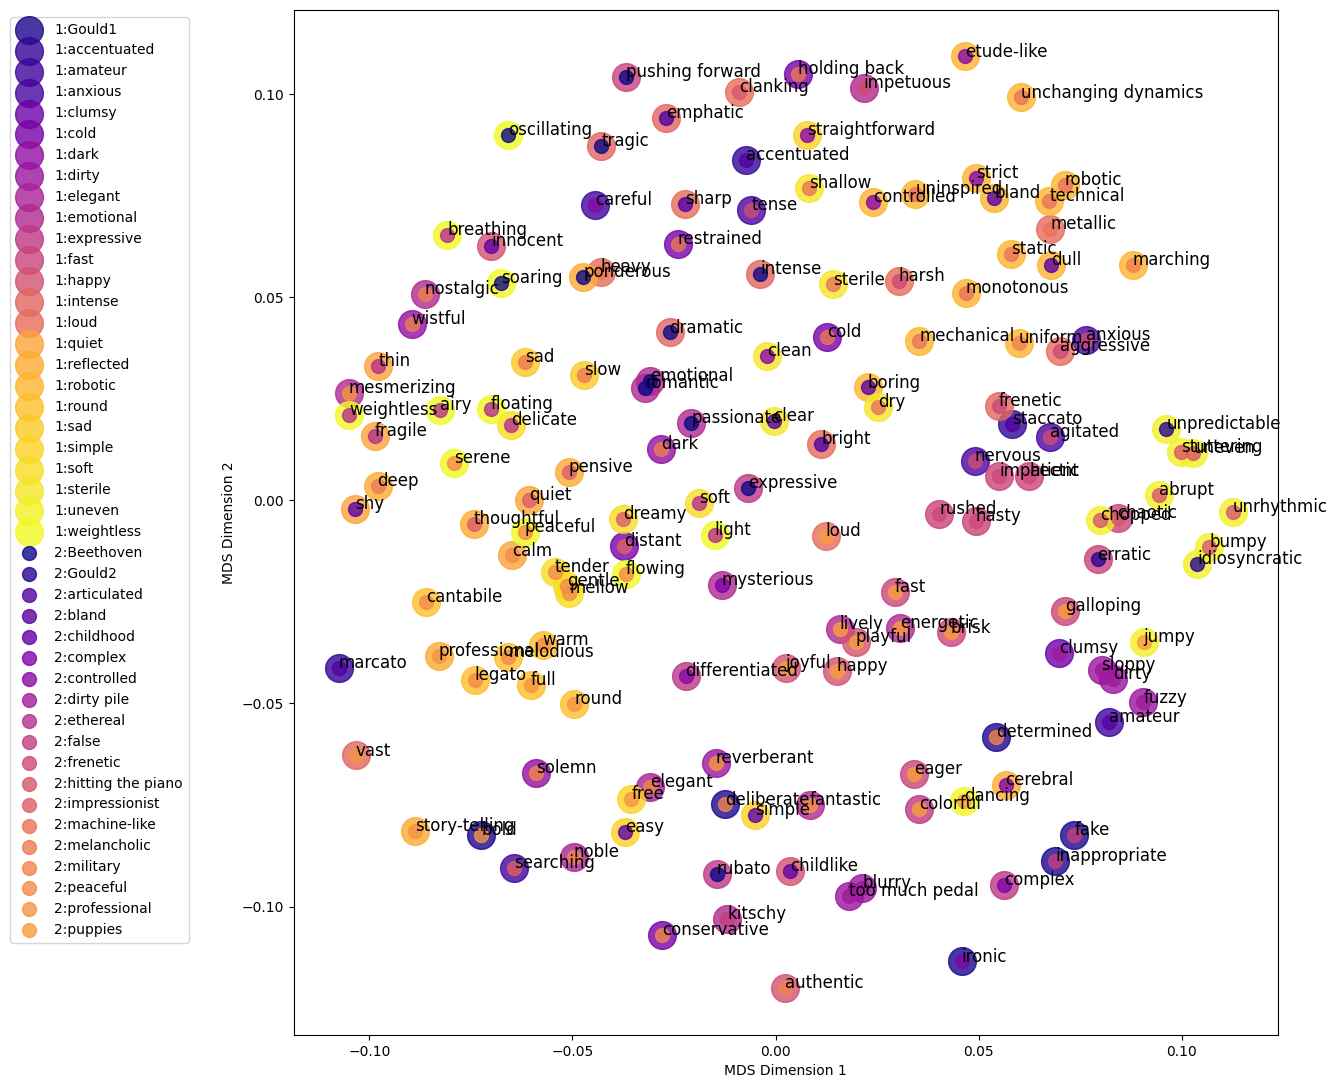

In [9]:
plot_mds(terms_mds, save_figure= False)

In [10]:
def plot_mds_perfs(mds_data,
             pile_names=pile_names,
             term_per_perf=term_per_perf,
             all_terms=terms,
             save_figure=False):
    """
    a full plot with PERFORMANCES colored according as polygons
    """
    
    fig, ax = plt.subplots(1, figsize=(13, 13))
    cmap= plt.get_cmap('gist_stern')
    term_per_perf_dict = term_per_perf.item()
    colors = np.array(list(iter(cmap(np.linspace(0,1,len(term_per_perf_dict.keys()))))))
    
    for p2, perf in enumerate(list(term_per_perf_dict.keys())):
        perf_idx = term_per_perf_dict[perf]
        # get convex hull around these points
        perf_mds_points = mds_data[perf_idx, :2]
        if len(perf_mds_points) <= 2:
            print("too few terms for convex hull of perf: ", perf)
            continue
        perf_hull = ConvexHull(perf_mds_points)
        # draw a transparent polygon
        ax.fill(perf_mds_points[perf_hull.vertices,0], 
                perf_mds_points[perf_hull.vertices,1], 
                c=colors[p2].reshape(1, -1), 
                alpha=0.1)               
        centroid = np.mean(perf_mds_points, axis=0)
        ax.scatter(centroid[ 0], centroid[ 1],
                  s=100, c=colors[p2].reshape(1, -1),
                  alpha=0.8, label=':: ' + perf)
        ax.annotate(pile_names[p2], centroid[:2], centroid[:2], fontsize=12)


    ax.set_xlabel('MDS Dimension 1')
    ax.set_ylabel('MDS Dimension 2')
    ax.set_xlim((-0.15, 0.151))
    ax.set_ylim((-0.15, 0.15))
    plt.legend(ncol=1, bbox_to_anchor=(-0.1,1), loc="upper right")
    ax.set_aspect('equal')
    fig.tight_layout()
    if save_figure:
        plt.savefig('MDS_plot.pdf')


In [11]:
def plot_mds_hull(mds_data,
             pile_names=pile_names,
             pile_idx_per_term=pile_idx_per_term,
             all_terms=terms,
             pile_group=1,
            text_size = 10,
             save_figure=False):
    """
    a full plot with PILES colored according as polygons, one pile group represented
    """


    
    fig, ax = plt.subplots(1, figsize=(13, 13))
    cmap= plt.get_cmap('plasma')
    colors = np.array(list(iter(cmap(np.linspace(0,1,len(pile_names))))))

    for p2 in np.unique(pile_idx_per_term[:, pile_group]):
        p2_idx = np.where(pile_idx_per_term[:, pile_group] == p2)[0]
        # get convex hull around these points
        p2_mds_points = mds_data[p2_idx, :2]
        if len(p2_mds_points) <= 2:
            print("too few terms for convex hull of pile: ", p2, pile_names[p2].replace("_"," "))
            continue
        p2_hull = ConvexHull(p2_mds_points)
        # draw a transparent polygon
        ax.fill(p2_mds_points[p2_hull.vertices,0], 
                p2_mds_points[p2_hull.vertices,1], 
                c=colors[p2].reshape(1, -1), 
                alpha=0.1)               
        centroid = np.mean(p2_mds_points, axis=0)
        ax.scatter(centroid[ 0], centroid[ 1],
                  s=100, c=colors[p2].reshape(1, -1),
                  alpha=0.8, label='2:' + pile_names[p2])
        ax.annotate(pile_names[p2], centroid[:2], centroid[:2], fontsize=text_size)

    ax.set_xlabel('MDS Dimension 1', fontsize=text_size)
    ax.set_ylabel('MDS Dimension 2', fontsize=text_size)
    #ax.set_xlim((-0.15, 0.151))
    #ax.set_ylim((-0.15, 0.15))
    # plt.legend(ncol=1, bbox_to_anchor=(-0.1,1), loc="upper right")
    ax.set_aspect('equal')
    plt.tight_layout()
    if save_figure:
        plt.savefig('MDS_convex_hull.png')

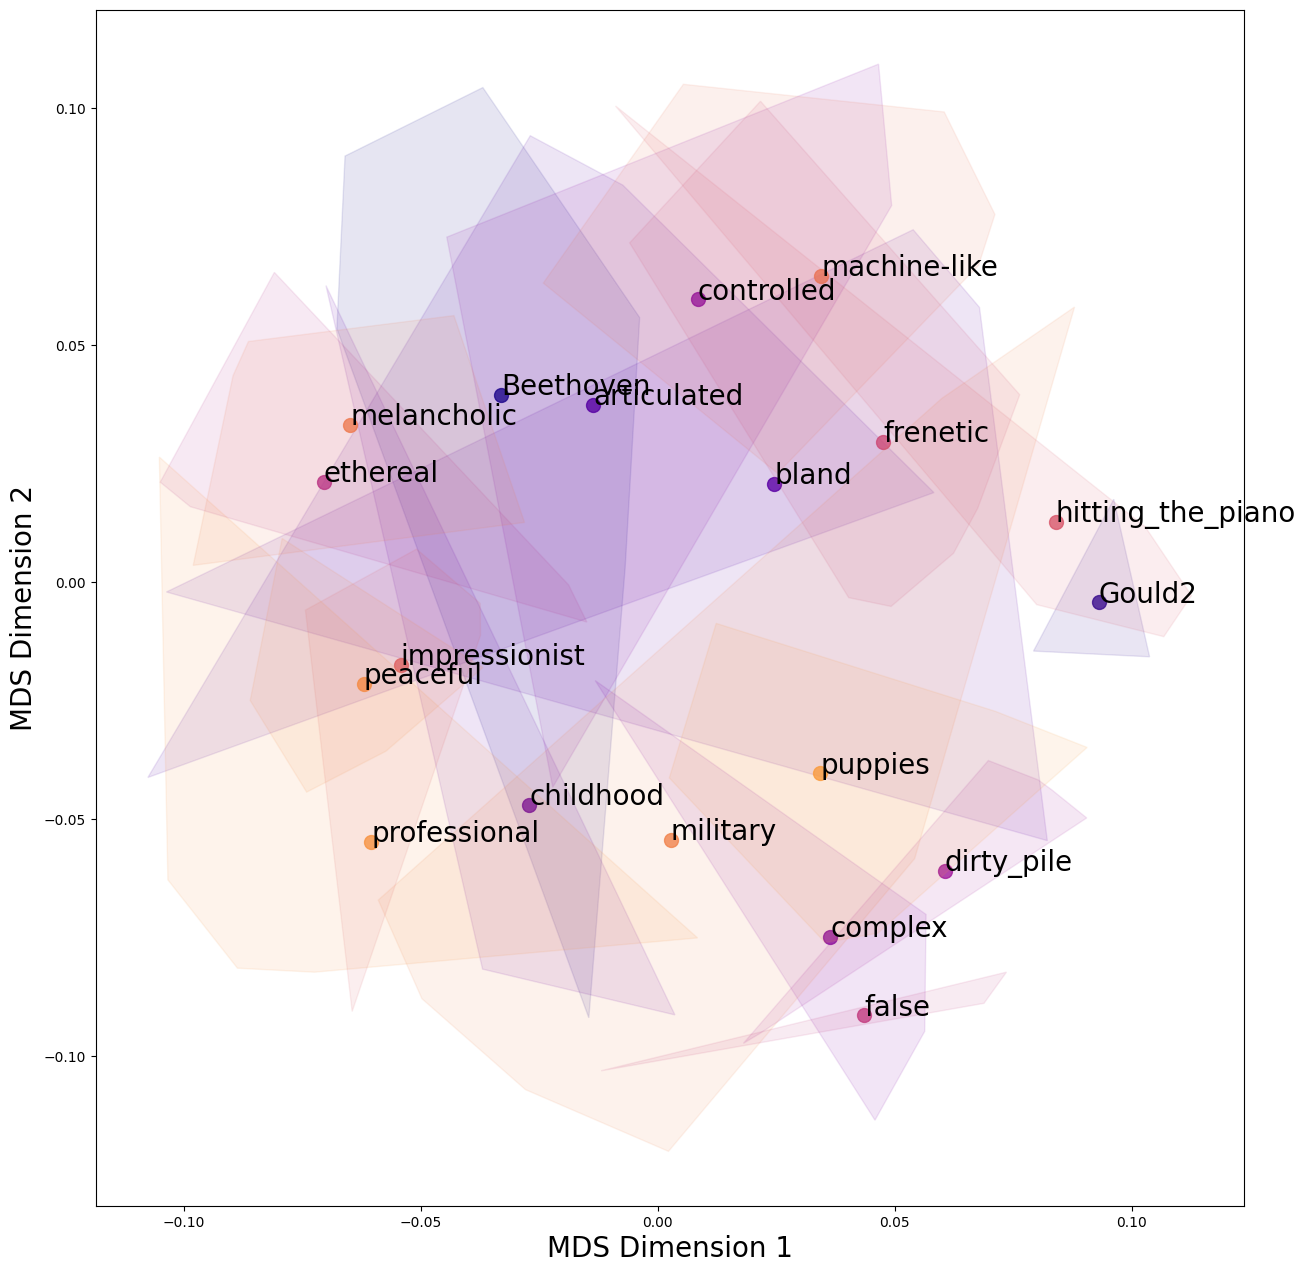

In [12]:
plot_mds_hull(terms_mds,text_size=20, save_figure= False)

## similarities audio and distributions

In [13]:
# performance embeddings based on scaled sum of occurence
perf_embeddings = np.matmul(term_freq,term_embeddings_clap_npy)
perf_embeddings = perf_embeddings / np.sqrt(np.outer((perf_embeddings**2).sum(axis=1), np.ones(1024)))
perf_similarity = np.matmul(perf_embeddings,perf_embeddings.T)

perf_embeddings_context = np.matmul(term_freq,term_embeddings_clap_context_npy)
perf_embeddings_context = perf_embeddings_context / np.sqrt(np.outer((perf_embeddings_context**2).sum(axis=1), np.ones(1024)))
perf_similarity_context = np.matmul(perf_embeddings_context,perf_embeddings_context.T)

# similarity between audio embeddings and individual term embeddings
audio_term_similarity = np.matmul(audio_embeddings,term_embeddings_clap_npy.T)
# similarity between audio embeddings and performance embeddings based on terms term embeddings
perf_term_audio_similarity = np.matmul(perf_embeddings,audio_embeddings.T)

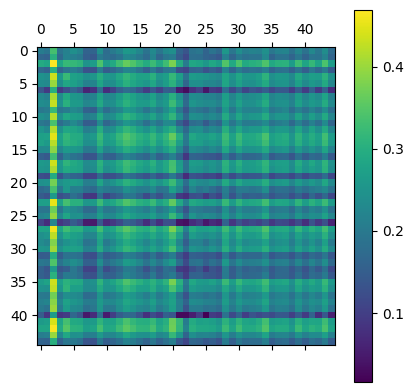

In [14]:
# "self similarity" of perf between audio and terms
plt.matshow(perf_term_audio_similarity)
plt.colorbar()

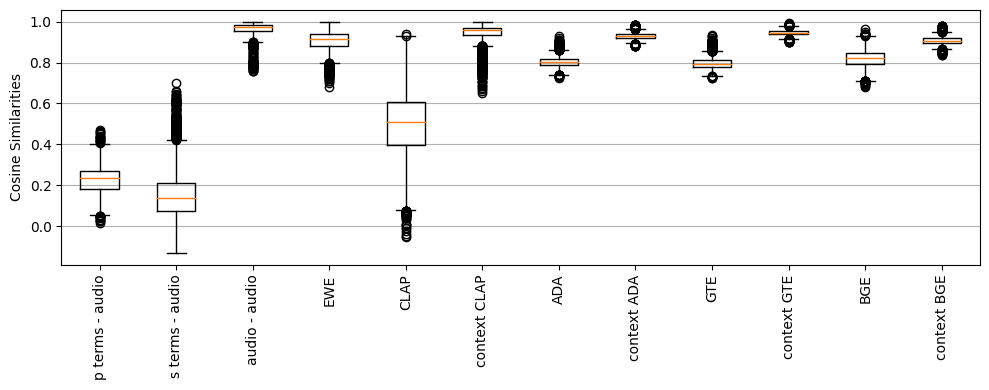

In [15]:
similarities = [
    (perf_term_audio_similarity, "p terms - audio", (0,0)),
    (audio_term_similarity, "s terms - audio", (0,1)),
    (similarity_audio[np.triu_indices(45,1)], "audio - audio", (0,2)),
    (similarity_ewe[np.triu_indices(150,1)], "EWE", (0,3)),
    (similarity_clap[np.triu_indices(150,1)], "CLAP", (1,0)),
    (similarity_clap_context[np.triu_indices(150,1)], "context CLAP", (1,1)),
    (similarity_ada[np.triu_indices(150,1)], "ADA", (1,2)),
    (similarity_ada_context[np.triu_indices(150,1)], "context ADA", (1,3)),
    (similarity_gte[np.triu_indices(150,1)], "GTE", (2,0)),
    (similarity_gte_context[np.triu_indices(150,1)], "context GTE", (2,1)),
    (similarity_bge[np.triu_indices(150,1)], "BGE", (2,2)),
    (similarity_bge_context[np.triu_indices(150,1)], "context BGE", (2,3)),
]

# plot box plot
fig, ax = plt.subplots(1, figsize = (10,4))
ax.boxplot([s[0].reshape(-1) for s in similarities])
#ax.set_title('Box plot')


ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(similarities))],
              labels=[s[1] for s in similarities],
             rotation=90)
# ax.set_xlabel('Embedding Spaces')
ax.set_ylabel('Cosine Similarities')
plt.tight_layout()
# plt.savefig("similarity_distributions.png")

### Kmeans and overlap

In [16]:
def piles_from_kmeans(datapoints, 
                      number = 20,
                     terms = terms):
    kmeans = KMeans(n_clusters=number, random_state=0, n_init="auto")
    kmeans.fit(datapoints)
    piles = defaultdict(list)  
    
    for i, pile_id in enumerate(kmeans.labels_):
        piles[pile_id].append(terms[i])

    return piles, kmeans.cluster_centers_, kmeans.labels_

def within_between( datapoints,
                    cluster_labels,
                  cluster_centers=None,
                  ratio = True):
    #kmeans.cluster_centers_
    #kmeans.labels_
    cluster_centers_computed = list()
    
    within_pile_distance = list()
    for pile_id in np.unique(cluster_labels):
        term_idx = np.where(cluster_labels == pile_id)[0]
        cluster_center = datapoints[term_idx].mean(axis=0)
        cluster_centers_computed.append(cluster_center)
        local_within_pile_distance = euclidean_distances(datapoints[term_idx])
        if len(term_idx) >= 2:
            av_local_within_pile_distance = np.mean(local_within_pile_distance[np.triu_indices(local_within_pile_distance.shape[0], 1)])
            within_pile_distance.append(av_local_within_pile_distance)      
    av_within_pile_distance = np.mean(within_pile_distance) 
    
    if cluster_centers is None:
        cluster_centers = cluster_centers_computed
    between_pile_distance = euclidean_distances(cluster_centers)
    av_between_pile_distance = np.mean(between_pile_distance[np.triu_indices(between_pile_distance.shape[0], 1)])
    if ratio:
        return av_within_pile_distance / av_between_pile_distance
    else:
        return av_between_pile_distance, av_within_pile_distance
    

In [17]:
all_mds = [   (term_embeddings_ada_npy, "term_embeddings_ada_npy"), 
              (term_embeddings_clap_npy, "term_embeddings_clap_npy"),
              (term_embeddings_gte_npy, "term_embeddings_gte_npy"),
              (term_embeddings_bge_npy, "term_embeddings_bge_npy"),
              (term_similarity, "term_similarity"),
              (rng.normal(0,1,(150,100)), "random baseline")  
          ]

all_mds_names = [val[1] for val in all_mds]

In [21]:
def szymkiewicz_simpson_coefficient(iter1, iter2):
    """
    Overlap coefficient
    """
    set1 = set(iter1)
    set2 = set(iter2)
    if len(set1) == 0 and len(set2) == 0:
        return 1
    else:
        aib = float(len(set1.intersection(set2)))
        return aib / min(len(set1), len(set2))


def pile_overlap(piles1, piles2):
    """
    Compute pile overlap
    """
    overlap = np.zeros((len(piles1), len(piles2)))
    pile_names1 = list(piles1.keys())
    pile_names1.sort()
    pile_names2 = list(piles2.keys())
    pile_names2.sort()
    for i, p1 in enumerate(pile_names1):
        for j, p2 in enumerate(pile_names2):
            overlap[i, j] = szymkiewicz_simpson_coefficient(piles1[p1],
                                                            piles2[p2])
    return overlap

In [22]:
overlap = pile_overlap(piles1.item(),piles2.item())
print(overlap.max(1).shape, overlap.max(1).mean())
print(overlap.max(0).shape, overlap.max(0).mean())
print("------")

data_kmeans = [[overlap.max(1).mean(), overlap.max(0).mean(), 0,0,0,0,0]]

for test_data, name in all_mds:
    print(name)
    kmeans_piles, cluster_centers, cluster_labels = piles_from_kmeans(test_data, number = 22)
    ratio= within_between(test_data, cluster_labels, cluster_centers)
    ratio_p1= within_between(test_data, pile_idx_per_term[:,0])
    ratio_p2= within_between(test_data, pile_idx_per_term[:,1])
    
    overlap1 = pile_overlap(piles1.item(),kmeans_piles)
    overlap2 = pile_overlap(piles2.item(),kmeans_piles)
    
    data_row = [overlap1.max(1).mean(), overlap1.max(0).mean(), 
                overlap2.max(1).mean(), overlap2.max(0).mean(),
                ratio_p1, ratio_p2, ratio]
    data_kmeans.append(data_row)
    print("---")
    print(overlap1.max(1).shape, overlap1.max(1).mean())
    print(overlap1.max(0).shape, overlap1.max(0).mean())
    print("---")
    print(overlap2.max(1).shape, overlap2.max(1).mean())
    print(overlap2.max(0).shape, overlap2.max(0).mean())
    print("------")

(25,) 0.6155295815295815
(19,) 0.6500417710944028
------
term_embeddings_ada_npy
---
(25,) 0.5541904761904761
(22,) 0.5752164502164502
---
(19,) 0.4784461152882205
(22,) 0.4303030303030303
------
term_embeddings_clap_npy
---
(25,) 0.5197619047619046
(22,) 0.5075757575757576
---
(19,) 0.47161654135338343
(22,) 0.45898268398268394
------
term_embeddings_gte_npy
---
(25,) 0.5887301587301587
(22,) 0.5935064935064935
---
(19,) 0.5338972431077694
(22,) 0.5207251082251082
------
term_embeddings_bge_npy
---
(25,) 0.5093333333333333
(22,) 0.5306818181818183
---
(19,) 0.5330827067669173
(22,) 0.4844221435130526
------
term_similarity
---
(25,) 0.6635555555555556
(22,) 0.7049357208448117
---
(19,) 0.6603383458646617
(22,) 0.6956136035681489
------
random baseline
---
(25,) 0.455
(22,) 0.46401515151515144
---
(19,) 0.4784461152882205
(22,) 0.4680375180375181
------


### Precision at K


In [27]:
def precision_at_k(test_similarities, 
                   reference_similarities,
                   k = 10,
                  second_array_as_kneighbor_graph=False):
    number_of_observations = len(test_similarities)
    precisions = np.zeros(number_of_observations)
    for elem_idx in np.arange(number_of_observations):
        sorted_ref = np.argsort(reference_similarities[elem_idx])
        sorted_test = np.argsort(test_similarities[elem_idx])
        if second_array_as_kneighbor_graph:
            intersect = np.intersect1d(sorted_test[-k-1:-1], sorted_ref[-k:])
        else:
            intersect = np.intersect1d(sorted_test[-k-1:-1], sorted_ref[-k-1:-1])
        # print(elem_idx, "test:", sorted_test[-2:]," ref: ",sorted_ref[-2:])
        precisions[elem_idx] = len(intersect)/np.min((k, number_of_observations-1))
        
    return np.mean(precisions)


In [28]:
similarities = [
    term_similarity,
    term_similarity_only_performances,
    term_similarity_only_piles,
    term_similarity_only_pile1,
    term_similarity_only_pile2,
    similarity_ada,
    similarity_clap
]

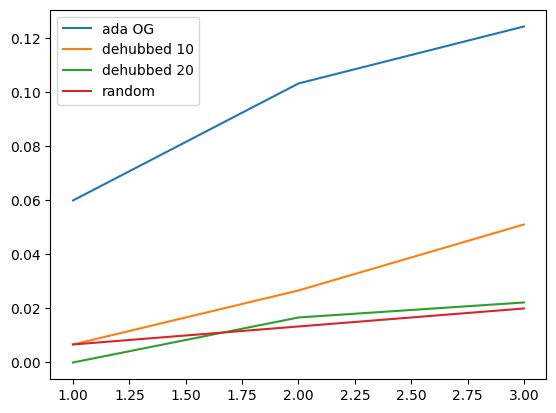

In [29]:
full_range = 4


precisions_k_ada = list()
for k in range(1,full_range):
    precisions = precision_at_k( similarity_ada,term_similarity, k = k)
    precisions_k_ada.append(precisions)
    
#1/(cosine_distances(pca.fit_transform(term_embeddings_clap_npy))+1e-14)
precisions_k_ada_pca = list()
for k in range(1,full_range):
    knn = KNeighborsTransformer(n_neighbors=10, metric="cosine")
    kneighbors_graph = knn.fit_transform(term_embeddings_ada_npy)
    mp = MutualProximity(method="normal")
    term_embeddings_ada_npy_dehubbed = mp.fit_transform(kneighbors_graph)

    precisions = precision_at_k(term_similarity,
                                np.asarray(term_embeddings_ada_npy_dehubbed.todense()) , 
                                k = k,
                               second_array_as_kneighbor_graph=True)
    precisions_k_ada_pca.append(precisions)
    
precisions_k_clap_pca = list()
for k in range(1,full_range):
    knn = KNeighborsTransformer(n_neighbors=20, metric="cosine")
    kneighbors_graph = knn.fit_transform(term_embeddings_ada_npy)
    mp = MutualProximity(method="normal")
    term_embeddings_ada_npy_dehubbed = mp.fit_transform(kneighbors_graph)
    
    precisions = precision_at_k(term_similarity, 
                                np.asarray(kneighbors_graph.todense()), 
                                k = k,
                               second_array_as_kneighbor_graph=True)
    precisions_k_clap_pca.append(precisions)



precisions_k_clapada = list()
for k in range(1,full_range):
    precisions_k_clapada.append(k/150)
    
plt.plot(np.arange(1,full_range),precisions_k_ada, label="ada OG")
plt.plot(np.arange(1,full_range),precisions_k_ada_pca, label="dehubbed 10")
plt.plot(np.arange(1,full_range),precisions_k_clap_pca, label="dehubbed 20")
plt.plot(np.arange(1,full_range),precisions_k_clapada, label="random")

plt.legend()

In [30]:
def dehub(embeddings, neighbors = 8):
    knn = KNeighborsTransformer(n_neighbors=neighbors, metric="cosine")
    kneighbors_graph = knn.fit_transform(embeddings)
    mp = MutualProximity(method="normal")
    kneighbors_graph_dehubbed = mp.fit_transform(kneighbors_graph)
    return np.array(kneighbors_graph_dehubbed.todense())

In [31]:
cmap= plt.get_cmap('plasma')
colors = np.array(list(iter(cmap(np.linspace(0,1,17)))))#[::-1]


similarities_paper_plot1 = [
    #(term_similarity_only_pile1, "piles 1 - GT", term_similarity, colors[0]),
    #(term_similarity_only_pile2, "piles 2 - GT", term_similarity, colors[1]),
    (term_similarity_only_pile1, "piles 1 - piles 2", term_similarity_only_pile2, colors[2]),
    (similarity_ewe, "EWE - GT",term_similarity, colors[6]),
    (similarity_clap, "CLAP - GT", term_similarity, colors[7]),
    #(similarity_clap_context, "context CLAP", term_similarity, colors[8]),
    (similarity_ada, "ADA - GT",term_similarity, colors[9]),
    #(similarity_ada_context, "context ADA", term_similarity, colors[10]),
    (similarity_gte, "GTE - GT", term_similarity, colors[11]),
    #(similarity_gte_context, "context GTE", term_similarity, colors[12]),
    (similarity_bge, "BGE - GT", term_similarity, colors[13]),
    #(similarity_bge_context, "context BGE", term_similarity, colors[14]),
]

similarities_paper_plot2 = [
    (term_similarity_only_pile1, "piles 1 - piles 2", term_similarity_only_pile2, colors[2]),
    (term_similarity_only_pile1, "piles 1 - performances", term_similarity_only_performances, colors[2]),
    (term_similarity_only_pile2, "piles 2 - performances", term_similarity_only_performances, colors[2]),
    #(term_similarity_only_piles, "piles - performances", term_similarity_only_performances),
    #(term_similarity_only_pile1, "piles 1 - gt", term_similarity, colors[3]),
    #(term_similarity_only_pile2, "piles 2 - gt", term_similarity, colors[4]),
    (term_similarity, "performances - gt", term_similarity_only_performances, colors[5]),
    (similarity_ada, "ADA",term_similarity, colors[9]),
]

similarities_paper_plot_audio = [
   # (similarity_clap, "CLAP text - GT", term_similarity, colors[2]),
   # (similarity_clap_context, "CLAP text context - GT", term_similarity, colors[2]),
    (similarity_audio, "CLAP audio - CLAP text", perf_similarity, colors[2]),
    (similarity_audio, "CLAP audio - CLAP text context ", perf_similarity_context, colors[2]),
]



similarities_paper_plot_context = [
    (similarity_clap, "CLAP", term_similarity, colors[7]),
    (similarity_clap_context, "context CLAP", term_similarity, colors[8]),
    (similarity_ada, "ADA",term_similarity, colors[9]),
    (similarity_ada_context, "context ADA", term_similarity, colors[10]),
    (similarity_gte, "GTE", term_similarity, colors[11]),
    (similarity_gte_context, "context GTE", term_similarity, colors[12]),
    (similarity_bge, "BGE", term_similarity, colors[13]),
    (similarity_bge_context, "context BGE", term_similarity, colors[14]),
]

similarity_clap_dehub = dehub(term_embeddings_clap_npy, neighbors = 8)
similarity_ada_dehub = dehub(term_embeddings_ada_npy, neighbors = 8)
similarity_gte_dehub = dehub(term_embeddings_gte_npy, neighbors = 8)
similarity_bge_dehub = dehub(term_embeddings_bge_npy, neighbors = 8)

similarities_paper_plot_dehub = [
    (similarity_clap, "CLAP", term_similarity, colors[7]),
    (term_similarity, "dehubbed CLAP", similarity_clap_dehub, "kneighborgraph"),
    (similarity_ada, "ADA",term_similarity, colors[9]),
    (term_similarity, "dehubbed ADA", similarity_ada_dehub, "kneighborgraph"),
    (similarity_gte, "GTE", term_similarity, colors[11]),
    (term_similarity, "dehubbed GTE", similarity_gte_dehub, "kneighborgraph"),
    (similarity_bge, "BGE", term_similarity, colors[13]),
    (term_similarity, "dehubbed BGE", similarity_bge_dehub, "kneighborgraph"),
]




In [32]:
def compute_precisions(list_of_similarities,
                      full_range = 50,
                      rb150 = True,
                      rb45 = False):
    precisions_k_paper = list()
    for test_similarity, name, ref_similarity, color in list_of_similarities:
        precisions_k = list()
        if color == "kneighborgraph":
            for k in range(1,full_range):
                precisions = precision_at_k( test_similarity,ref_similarity, k = k, second_array_as_kneighbor_graph=True)
                precisions_k.append(precisions)
        else:
            for k in range(1,full_range):
                precisions = precision_at_k( test_similarity,ref_similarity, k = k)
                precisions_k.append(precisions)

        precisions_k_paper.append((precisions_k, name, color))
    
    if rb150:
        precisions_k_random = list()
        for k in range(1,full_range):
            precisions_k_random.append(k/150)
        precisions_k_paper.append((precisions_k_random, "random baseline 150", colors[16]))

    if rb45:
        precisions_k_random = list()
        for k in range(1,full_range):
            precisions_k_random.append(np.min((k/45,1)))
        precisions_k_paper.append((precisions_k_random, "random baseline 45", colors[16])) 
    return precisions_k_paper

def compute_ratios(precisions_k_paper, number = 4):
    
    precisions_k_paper_ratio = list()
    for i in range(0,number*2,2):
        ratio = np.array(precisions_k_paper[i+1][0])/np.array(precisions_k_paper[i][0])
        precisions_k_paper_ratio.append((ratio, precisions_k_paper[i+1][1], precisions_k_paper[i+1][2]))

    return precisions_k_paper_ratio


C:\Users\silva\AppData\Local\Temp\ipykernel_17224\3283297331.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == "kneighborgraph":


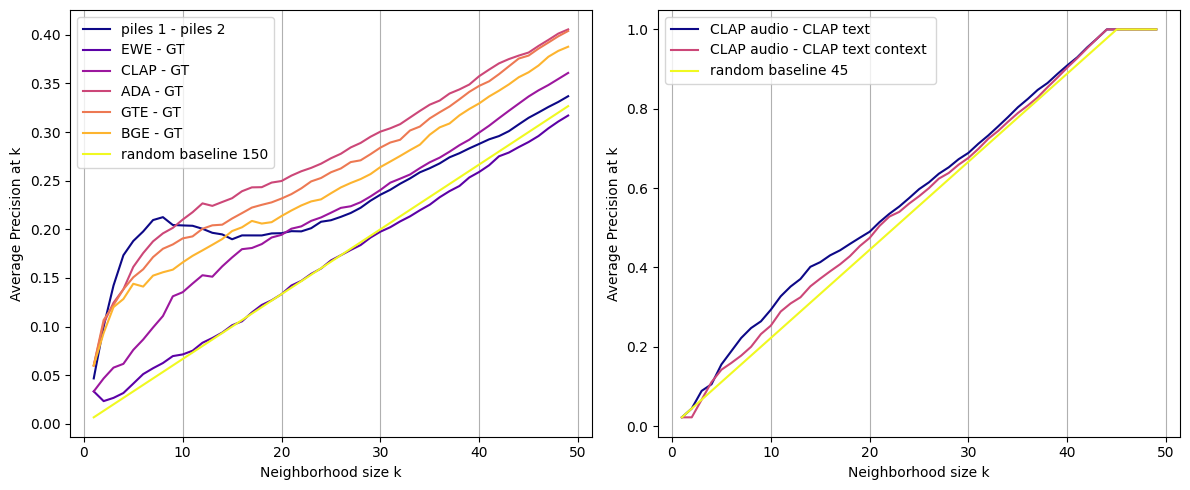

In [33]:
full_range = 50
cmap= plt.get_cmap('plasma')

precisions_k_paper_1 = compute_precisions(similarities_paper_plot1,full_range = full_range)
precisions_k_paper_2 = compute_precisions(similarities_paper_plot_audio,full_range = full_range, rb150=False, rb45=True)
fig, ax = plt.subplots(1,2,figsize=(12, 5))

#precisions_k_paper_2 = compute_ratios(precisions_k_paper_2)

k = 0
colors_local = np.array(list(iter(cmap(np.linspace(0,1,len(precisions_k_paper_1))))))
for data, name, color in precisions_k_paper_1:
    ax[0].plot(np.arange(1,full_range),data, label=name, c = colors_local[k])
    k += 1
                       
k = 0                    
colors_local = np.array(list(iter(cmap(np.linspace(0,1,len(precisions_k_paper_2))))))
for data, name, color in precisions_k_paper_2:
    ax[1].plot(np.arange(1,full_range),data, label=name, c = colors_local[k])
    k += 1
    

ax[0].set_ylabel('Average Precision at k')
ax[0].set_xlabel('Neighborhood size k')
ax[1].set_ylabel('Average Precision at k')
ax[1].set_xlabel('Neighborhood size k')
ax[0].xaxis.grid(True)
ax[1].xaxis.grid(True)


ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig("prec_at_k.png")

C:\Users\silva\AppData\Local\Temp\ipykernel_17224\3283297331.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if color == "kneighborgraph":


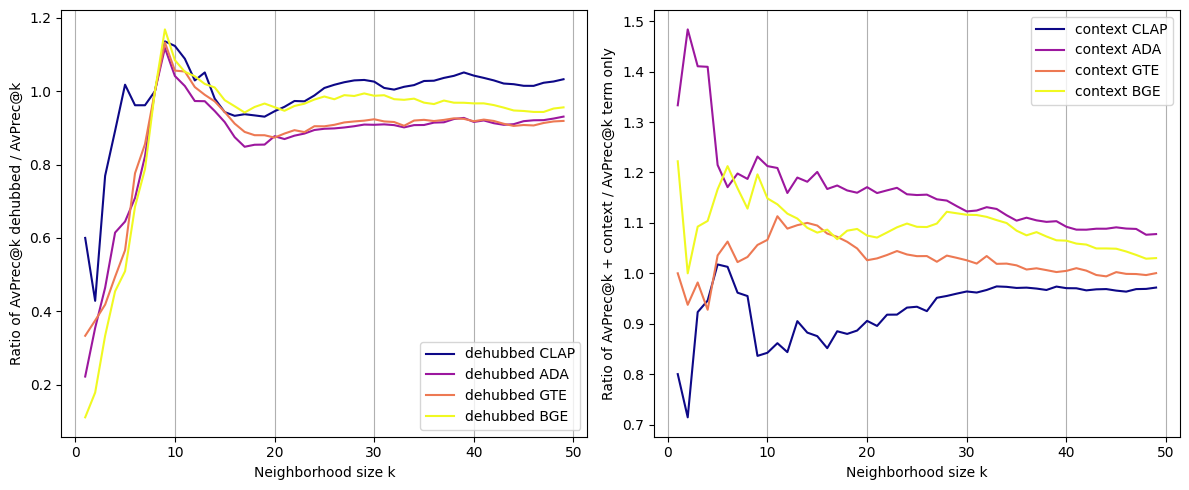

In [34]:
full_range = 50
cmap= plt.get_cmap('plasma')

precisions_k_paper_1 = compute_precisions(similarities_paper_plot_context,full_range = full_range)
precisions_k_paper_2 = compute_precisions(similarities_paper_plot_dehub,full_range = full_range)
fig, ax = plt.subplots(1,2,figsize=(12, 5))

precisions_k_paper_1 = compute_ratios(precisions_k_paper_1)
precisions_k_paper_2 = compute_ratios(precisions_k_paper_2)

k = 0
colors_local = np.array(list(iter(cmap(np.linspace(0,1,len(precisions_k_paper_1))))))
for data, name, color in precisions_k_paper_1:
    ax[1].plot(np.arange(1,full_range),data, label=name, c = colors_local[k])
    k += 1
                       
k = 0                    
colors_local = np.array(list(iter(cmap(np.linspace(0,1,len(precisions_k_paper_2))))))
for data, name, color in precisions_k_paper_2:
    ax[0].plot(np.arange(1,full_range),data, label=name, c = colors_local[k])
    k += 1
    
ax[1].set_ylabel('Ratio of AvPrec@k + context / AvPrec@k term only')
ax[1].set_xlabel('Neighborhood size k')
ax[0].set_ylabel('Ratio of AvPrec@k dehubbed / AvPrec@k')
ax[0].set_xlabel('Neighborhood size k')
ax[1].xaxis.grid(True)
ax[0].xaxis.grid(True)


ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig("context_hubness.png")

### Hubness

In [35]:
from skhubness import Hubness
from skhubness.reduction import MutualProximity
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer

names = ["ada",
         #"clap",
         #"term frequency",
         #"random"
        ]
for k in [2,4,8,16]:
    print("---------------------------------------")
    print("testing hubness for k neighbors, k = ", k)
    for test_id, test_data in enumerate([
        term_embeddings_ada_npy, 
        #term_embeddings_clap_npy, 
        #term_freq.T ,
        #np.random.normal(0,1,(15000, 1000))
    ]):
        print("-------")
        print(names[test_id])
        
        knn = KNeighborsTransformer(n_neighbors=k, metric="cosine")
        kneighbors_graph = knn.fit_transform(test_data)
        mp = MutualProximity(method="normal")
        test_data_dehubbed = mp.fit_transform(kneighbors_graph)
        
        
        hub = Hubness(k=k, metric='cosine')
        hub.fit(kneighbors_graph)
        k_skew = hub.score()
        print(f'Skewness = {k_skew:.3f}')

        hub2 = Hubness(k=k, metric='cosine',
                      return_value='robinhood')
        hub2.fit(kneighbors_graph)  
        rh = hub2.score()
        print(f'Robinhood = {rh:.3f}')
        
        print("now with reduced hubness!")
        


        
        hub = Hubness(k=k, metric='cosine')
        hub.fit(test_data_dehubbed)
        k_skew = hub.score()
        print(f'Skewness = {k_skew:.3f}')

        hub2 = Hubness(k=k, metric='cosine',
                      return_value='robinhood')
        hub2.fit(test_data_dehubbed)  
        rh = hub2.score()
        print(f'Robinhood = {rh:.3f}')
        


---------------------------------------
testing hubness for k neighbors, k =  2
-------
ada
Skewness = 1.260
Robinhood = 0.193
now with reduced hubness!
Skewness = 0.745
Robinhood = 0.157
---------------------------------------
testing hubness for k neighbors, k =  4
-------
ada
Skewness = 0.993
Robinhood = 0.247
now with reduced hubness!
Skewness = 0.875
Robinhood = 0.207
---------------------------------------
testing hubness for k neighbors, k =  8
-------
ada
Skewness = 1.115
Robinhood = 0.249
now with reduced hubness!
Skewness = 0.580
Robinhood = 0.210
---------------------------------------
testing hubness for k neighbors, k =  16
-------
ada
Skewness = 0.813
Robinhood = 0.257
now with reduced hubness!
Skewness = 0.315
Robinhood = 0.237


In [36]:


names = ["ada",
         "clap",
         "gte",
         "bge",
         #"term frequency",
         "random",
        ]
global_data = list()

for k in [4,8,16]:
    print("---------------------------------------")
    print("testing hubness for k neighbors, k = ", k)
    for test_id, test_data in enumerate([
        term_embeddings_ada_npy, 
        term_embeddings_clap_npy, 
        term_embeddings_gte_npy, 
        term_embeddings_bge_npy, 
        #term_freq.T,
        rng.normal(0,1,(15000, 1000))
    ]):
        data = [test_id, k]
        knn = KNeighborsTransformer(n_neighbors=k, metric="cosine")
        kneighbors_graph = knn.fit_transform(test_data)
        mp = MutualProximity(method="normal")
        test_data_dehubbed = mp.fit_transform(kneighbors_graph)
        
        
        hub = Hubness(k=k,  return_value="all", metric='cosine')
        score = hub.fit(kneighbors_graph).score()
        score_dehub = hub.fit(test_data_dehubbed).score()

        data += [score.get("k_skewness"), score_dehub.get("k_skewness"), score.get("robinhood"), score_dehub.get("robinhood")]
        
        global_data.append(data)
        
global_data_npy = np.array(global_data)


---------------------------------------
testing hubness for k neighbors, k =  4
---------------------------------------
testing hubness for k neighbors, k =  8
---------------------------------------
testing hubness for k neighbors, k =  16


In [38]:
global_data_npy

array([[ 0.        ,  4.        ,  0.99317312,  0.8752346 ,  0.24666667,
         0.20666667],
       [ 1.        ,  4.        ,  1.09078144,  0.52119021,  0.22333333,
         0.18666667],
       [ 2.        ,  4.        ,  1.10727088,  0.9144573 ,  0.23666667,
         0.205     ],
       [ 3.        ,  4.        ,  1.7649984 ,  1.14090228,  0.32333333,
         0.28666667],
       [ 4.        ,  4.        ,  0.5857813 ,  0.37619119,  0.16725   ,
         0.1342    ],
       [ 0.        ,  8.        ,  1.11514008,  0.58002446,  0.24916667,
         0.21      ],
       [ 1.        ,  8.        ,  1.18993031,  0.53561568,  0.25083333,
         0.22583333],
       [ 2.        ,  8.        ,  1.12801892,  0.44363662,  0.2375    ,
         0.20666667],
       [ 3.        ,  8.        ,  1.96842347,  1.63032755,  0.38833333,
         0.36416667],
       [ 4.        ,  8.        ,  0.38741176,  0.22277591,  0.12988333,
         0.10613333],
       [ 0.        , 16.        ,  0.81250714,  0.